In [1]:
import numpy as np
import scipy.io
from numpy.random import multivariate_normal
from scipy.linalg import cho_factor, cho_solve

In [8]:
# colors:
dark = np.array([51.0, 51.0, 51.0]) / 255.0
red = np.array([141.0, 45.0, 57.0]) / 255.0
gold = np.array([174.0, 159.0, 109.0]) / 255.0
gray = np.array([175.0, 179.0, 183.0]) / 255.0
lred = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - red)
lgold = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - gold)

## Gaussian inference on linear functions

In [5]:
def phi(a):  # phi(a) = [1,a]
    return np.power(a, range(3))

Some other options for the feature functions to try. Try around! Try scaling and changing the prior and/or the features (note that there are a few degrees of freedom shared between them)

In [33]:
def phi(a):
    # linear
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T)) - np.linspace(-8, 8, 8)

In [ ]:
def phi(a):
    return 2 * (a > np.linspace(-8, 8, 8).T)  # steps that switch on

In [ ]:
def phi(a):  # steps that change sign
    return 2 * ((a > np.linspace(-8, 8, 8).T) - 0.5)

In [41]:
def phi(a):
    # linear
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T) - np.linspace(-8, 8, 8))

In [34]:
def phi(a):
    # ReLU: 
    F = 265
    return 1 * (a - np.linspace(-8.1, 8, F).T) * (a > np.linspace(-8.1, 8, F).T)

In [52]:
def phi(a):  # Fourier features
    return 3 * np.hstack((np.sin(a * np.arange(4)), np.cos(a * np.arange(4))))

In [ ]:
def phi(a):
    return 5 * np.exp(
        -((a - np.linspace(-8, 8, 12).T) ** 2) / 2.0 / 0.5 ** 2
    )  # Gaussian / RBF / SE features

In [ ]:
def phi(a):  # "Eiffel towers"
    return 5 * np.exp(-np.abs(a - np.linspace(-8, 8, 12).T) / 1 ** 2)

In [37]:
""" ==== PARAMETRIC GAUSSIAN REGRESSION IN PYTHON ====
    this is didactic code. 
    In practice, you can and should obviously write this 
    in a more re-usable (be it functional or object-oriented) 
    style. The point is to show that everything here involves
    simple low-level operations (at most, numpy.linalg). There 
    is no "deep learning package" here, and no stochastic optimizer. 
"""
# first, define the prior
F = len(phi(0))  # number of features
# set parameters of prior on the weights
mu = np.zeros((F, 1))
Sigma = 10 * np.eye(F) / F  # p(w)=N(mu,Sigma)

# construct implied prior on f_x
n = 100  # number of grid-points, for plotting
x = np.linspace(-8, 8, n)[:, np.newaxis]  # reshape is needed for phi to work
m = phi(x) @ mu
kxx = phi(x) @ Sigma @ phi(x).T  # p(f_x)=N(m,k_xx)
s = multivariate_normal(m.flatten(), kxx + 1e-6 * np.eye(n), size=5).T
stdpi = np.sqrt(np.diag(kxx))[:, np.newaxis]  # marginal stddev, for plotting

# then, load data from disk
data = scipy.io.loadmat("nlindata.mat")
# import scipy.io; data = scipy.io.loadmat('nlindata.mat') # use this line to get the nonlinear data.
X = data["X"]  # inputs
Y = data["Y"]  # outputs
sigma = float(data["sigma"])  # measurement noise std-deviation
N = len(X)  # number of data

# evidence: p(Y) = N(Y;M,kXX + sigma**2 * no.eye(N))
M = phi(X) @ mu
kXX = phi(X) @ Sigma @ phi(X).T  # p(f_X) = N(M,k_XX)
G = kXX + sigma ** 2 * np.eye(N)

# now, do inference (i.e. construct the posterior)
# the following in-place decomposition is the most expensive step at O(N^3):
G = cho_factor(G)
kxX = phi(x) @ Sigma @ phi(X).T  # Cov(f_x,f_X) = k_xX
A = cho_solve(G, kxX.T).T  # pre-compute for re-use (but is only O(N^2))

# # posterior p(f_x|Y) = N(f_x,mpost,vpost)
mpost = m + A @ (Y - M)  # mean
vpost = kxx - A @ kxX.T  # covariance
spost = multivariate_normal(mpost.flatten(), vpost  + 1e-6 * np.eye(n), size=5).T  # samples
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]  # marginal stddev, for plotting

## plotting

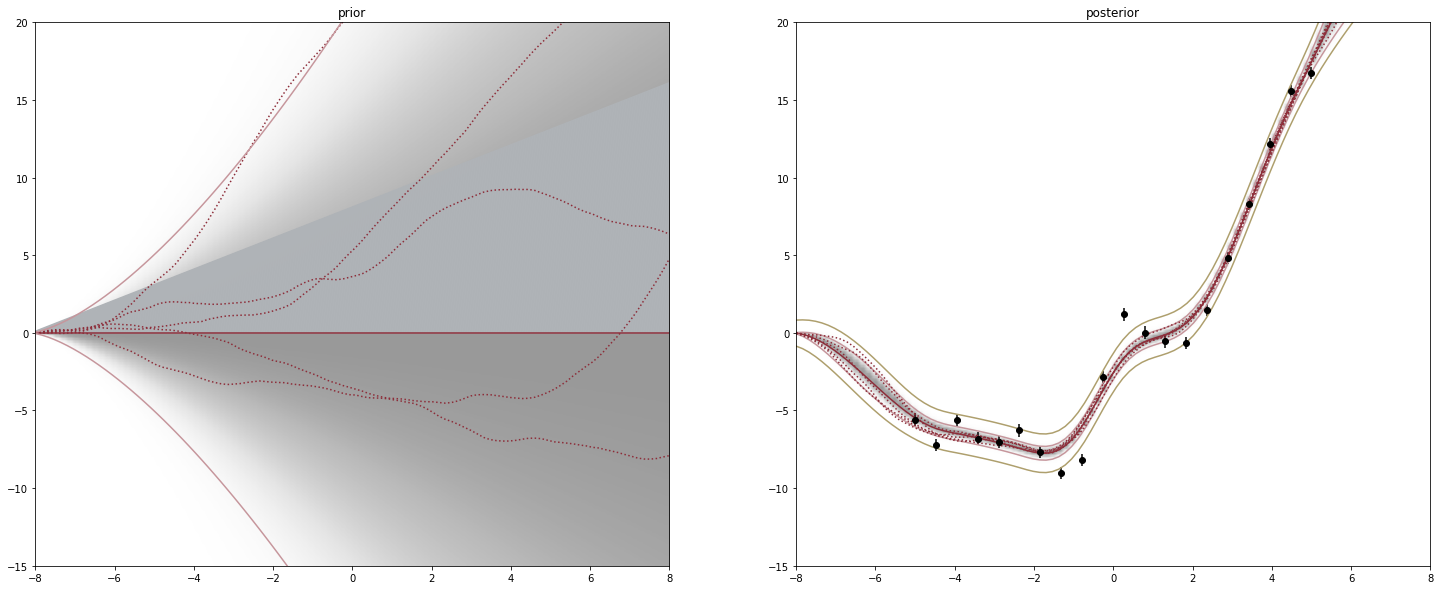

In [38]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25, 10)
fig, ax = plt.subplots(1, 2)


def GaussPDFscaled(y, m, s):  # shading
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


yy = np.linspace(-15, 20, 200).reshape([200, 1])
P = GaussPDFscaled(yy, m, stdpi)

ax[0].imshow(
    P, extent=[-8, 8, -15, 20], aspect="auto", origin="lower", cmap="Greys", alpha=0.4
)
ax[0].plot(x, phi(x), "-", color=gray)
ax[0].plot(x, s, ":", color=red)  # prior
ax[0].plot(x, m, "-", color=red)
ax[0].plot(x, m + 2 * stdpi, "-", color=lred)
ax[0].plot(x, m - 2 * stdpi, "-", color=lred)
ax[0].set(xlim=[-8, 8], ylim=[-15, 20], title="prior")

Ppost = GaussPDFscaled(yy, mpost, stdpo)  # shading by local marginal pdf
ax[1].imshow(
    Ppost,
    extent=[-8, 8, -15, 20],
    aspect="auto",
    origin="lower",
    cmap="Greys",
    alpha=0.4,
)
ax[1].errorbar(X, Y, yerr=sigma, fmt="ok")  # data
ax[1].plot(x, mpost, "-", color=red)  # posterior mean
ax[1].plot(x, mpost + 2 * stdpo, "-", color=lred)  # upper error bars on f
ax[1].plot(x, mpost - 2 * stdpo, "-", color=lred)  # lower error bars on f

ax[1].plot(
    x, mpost + 2 * stdpo + 2 * sigma, "-", color=gold
)  # predictive error bars (on y)
ax[1].plot(x, mpost - 2 * stdpo - 2 * sigma, "-", color=gold)

ax[1].plot(x, spost, ":", color=red)  # samples
ax[1].set(xlim=[-8, 8], ylim=[-15, 20], title="posterior")

plt.show()